Importa as bibliotecas necessárias

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import datetime
import math
import chart_studio.plotly as py
from pathlib import Path
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statistics
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())

DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"

DIR_MODIFICADO = DIRETORIO_DATASET / "dataset_modificado"
DIR_QUANTITATIVOS = DIRETORIO_PRINCIPAL / "quantitativos"
DIR_ESTATISTICAS = DIRETORIO_PRINCIPAL / "estatisticas"
#DIRETORIO_PRINCIPAL = Path(r"D:\Projeto_PA" / "Projeto_PA_validado")

# define que pacientes com mais de 70% das medidas faltantes são descartados
LIMIAR_DE_DESCARTE = 0.7


In [6]:

#biblioteca do kmeans
from sklearn.cluster import KMeans

#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt

#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math


from IPython.display import Image
from pathlib import Path

Carrega a base de dados e exibe os 5 primeiros pacientes

In [7]:

df = pd.read_csv(DIR_MODIFICADO / "pacientes_completos_tratados.csv", sep=";", encoding="Latin1")

df.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,sist 9:00,sist 9:15,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
0,4,1923-10-05,1,94.0,85.0,160,33.2,2018-09-10 12:25:23,105.0,108.0,...,118.5,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34
1,5,1948-10-07,1,70.0,80.0,165,29.4,2018-12-26 07:39:41,103.0,114.0,...,106.0,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23
2,6,1999-03-23,1,19.0,100.0,197,25.8,2018-12-26 08:06:19,147.0,148.0,...,133.0,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2018-12-26 08:19:06,140.0,139.0,...,131.0,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9
4,8,1990-03-07,1,28.0,120.0,172,40.6,2018-12-26 08:26:59,113.0,110.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11


In [8]:
medidas = df.loc[:,'sist 9:00':'diast 8:45']
medidas_array = np.array(medidas)

In [9]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [10]:
### PCA

medidas_array_escala = StandardScaler().fit_transform(medidas_array)
pca = PCA(n_components = 2)

componentesPrincipais = pca.fit_transform(medidas_array_escala)

# Cria um dataframe contendo as componentes principais calculadas
dadosComponentesPrincipais = pd.DataFrame(data = componentesPrincipais, 
                                          columns = ['principal component 1', 'principal component 2'])

In [12]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)


[63.47338067 14.01909233]
[0.38701272 0.08547783]


In [13]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
#  Calcula o K-means com a saída do PCA
%time sum_of_squares = calculate_wcss(componentesPrincipais)
num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
print(num_otimo_clusters)

#convertendo os dados para a clusterização
X = np.array(componentesPrincipais)

#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(X)

#listar os grupos 
grupos = kmeans.fit_predict(X)
print(set(grupos))

Wall time: 27.8 s
7
{0, 1, 2, 3, 4, 5, 6}


Wall time: 0 ns


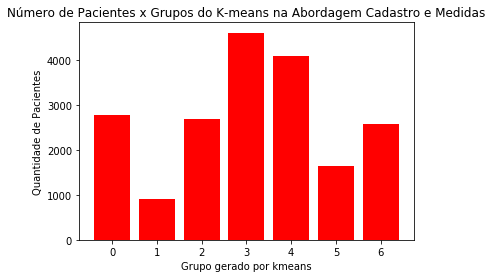

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0
Accuracy: 0.9958473916428757 - Recall: 0.9945647976165999 - F1 Score: 0.9953048369987311


In [14]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
%time random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo

classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,num_otimo_clusters):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Cadastro e Medidas')
fig = plt.gcf()
#fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

#treino
random_forest.fit(x_train, y_train)

#### Abordagem 1: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 1: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [15]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1116,0,2,0,0,0,0
1,0,356,0,0,0,1,2
2,1,0,1070,0,6,0,0
3,1,0,0,1792,1,1,0
4,2,0,3,1,1637,0,0
5,4,0,0,3,0,651,3
6,0,0,0,0,0,1,1052


In [16]:

#validacao
#pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
#pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
#pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val
#
#pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
##teste
#pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
#pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
#pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test
#
#pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
#             sep=';',index=False,encoding='UTF-8')


#### Abordagem 1: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
ls_cadastro = ['principal component 1', 'principal component 2']
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

importancia

,importance
features,
principal component 1,0.766
principal component 2,0.234


In [17]:
lista_porcentagem =list()
lista_porcentagem.append(np.round(100 * pca.components_[0], 2))
lista_porcentagem.append(np.round(100 * pca.components_[1], 2))
                         
nome_colunas = list(df.loc[:,'sist 9:00':'diast 8:45'].columns)
importancia_df = pd.DataFrame(lista_porcentagem,columns = nome_colunas, index =ls_cadastro )
importancia_df

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
principal component 1,7.45,7.48,7.52,7.60,7.67,7.67,7.72,7.70,7.66,7.69,...,7.39,8.06,7.53,7.65,7.75,7.78,7.86,7.95,7.98,8.02
principal component 2,7.94,7.67,7.45,7.05,6.50,6.40,6.02,5.83,5.55,5.39,...,-2.16,-2.77,-3.05,-3.32,-3.96,-4.35,-5.20,-5.85,-6.46,-6.86


In [18]:
componente_1_maior = max(importancia_df.loc['principal component 1',:])
componente_2_maior = max(importancia_df.loc['principal component 2',:])

In [19]:
maximo1 = list()
maximo2 = list()
for coluna in list(importancia_df.columns):
    if importancia_df.loc['principal component 1',coluna] == componente_1_maior:
        maximo1.append(coluna)
    if importancia_df.loc['principal component 2',coluna] == componente_2_maior:
        maximo2.append(coluna)

print(maximo1)
print(maximo2)

['diast 19:00']
['sist 6:15']
